# Assignment 2

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [15]:
df_order=pd.read_csv('datasets/data_orders.csv')
df_offer=pd.read_csv('datasets/data_offers.csv')

In [16]:
df_gett = df_order

# Mapping binary column values to categorical labels
df_gett["is_driver_assigned"] = np.where(df_gett["is_driver_assigned_key"] == 1, "Yes", "No")
df_gett["order_status"] = np.where(df_gett["order_status_key"] == 4, "Client Cancelled", "System Cancelled")

# Removing duplicate entries based on unique order identifiers
df_gett.drop_duplicates(subset=['order_gk'], inplace=True)

# Dropping unnecessary columns
df_gett.drop(columns=["is_driver_assigned_key", "order_status_key"], inplace=True)

# Renaming columns for clarity
df_gett.rename({'order_status':'Order Status'}, axis=1, inplace=True)


### Q1

In [17]:
# Grouping DataFrame by 'is_driver_assigned' and 'Order Status', and counting the number of orders
df_failure_reason = df_gett.groupby(by=['is_driver_assigned', 'Order Status'])['order_gk'].count().reset_index()

# Renaming the count column for clarity
df_failure_reason.rename({'order_gk': 'Order Count'}, axis=1, inplace=True)
df_failure_reason

,is_driver_assigned,Order Status,Order Count
0,No,Client Cancelled,4496
1,No,System Cancelled,3406
2,Yes,Client Cancelled,2811
3,Yes,System Cancelled,3


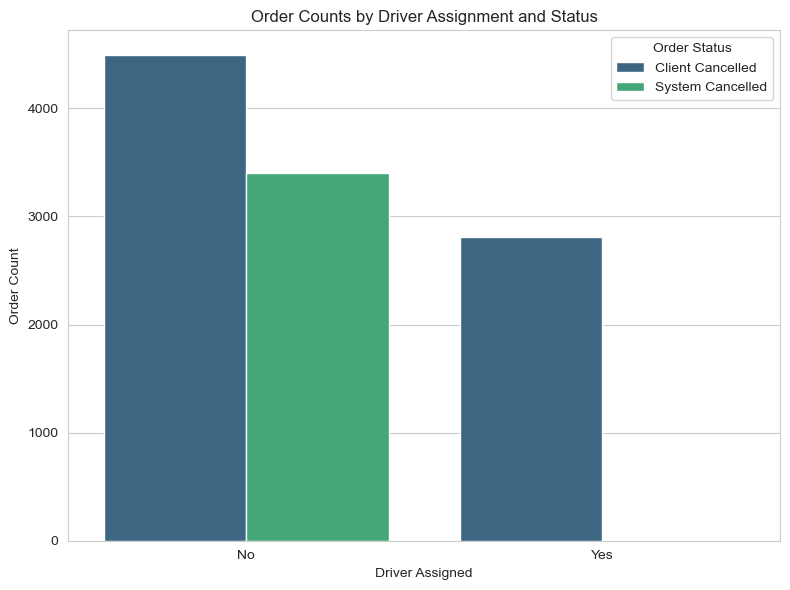

In [18]:
sns.set_style('whitegrid')

plt.figure(figsize=(8, 6))
sns.barplot(x='is_driver_assigned', y='Order Count', hue='Order Status', data=df_failure_reason, palette='viridis')
plt.title('Order Counts by Driver Assignment and Status')
plt.xlabel('Driver Assigned')
plt.ylabel('Order Count')
plt.tight_layout()

plt.savefig("figures/Q1.jpg", dpi=400)
plt.show()

### Q2

In [19]:
# Extracting the hour from the order_datetime column and assigning it to a new column 'Order Hour'
df_gett['Order Hour'] = df_gett['order_datetime'].str.split(":").apply(lambda split: split[0])

# Grouping DataFrame by 'Order Hour', 'is_driver_assigned', and 'Order Status', and counting the number of orders
df_byhour = df_gett.groupby(by=['Order Hour', 'is_driver_assigned', 'Order Status'])['order_gk'].count().reset_index()

# Renaming the count column for clarity
df_byhour.rename({'order_gk': 'Order Count'}, axis=1, inplace=True)
df_byhour.rename({'is_driver_assigned': 'Driver Assigned'}, axis=1, inplace=True)


C:\Users\john\AppData\Local\Temp\ipykernel_11536\1560442474.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Order Hour', y='Order Count', hue='Driver Assigned', style='Order Status', markers=True,


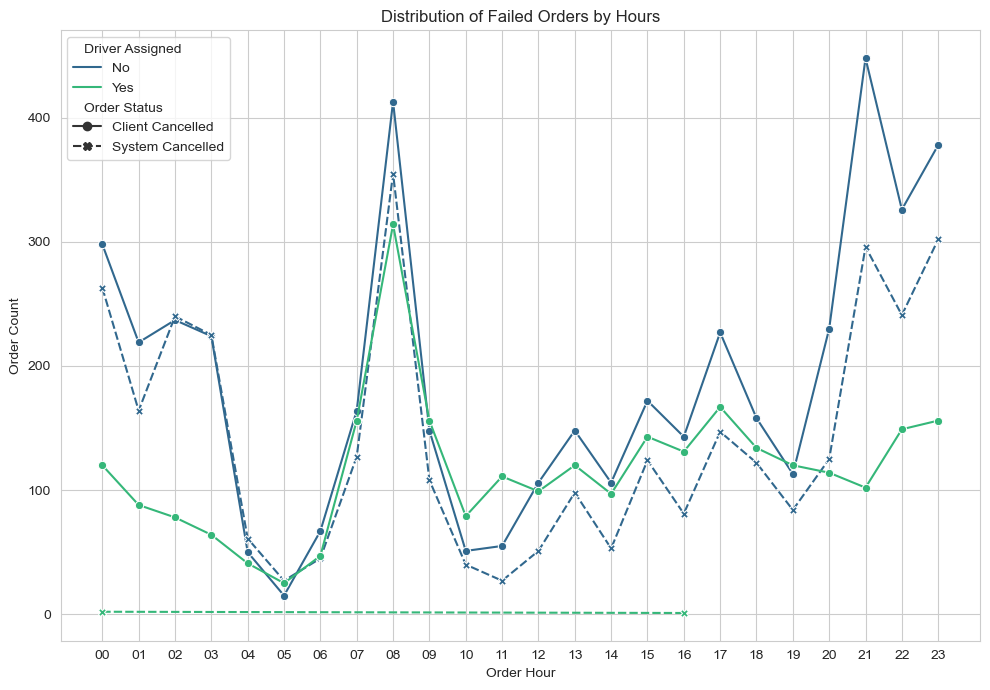

In [20]:
sns.set_style('whitegrid')

# 创建折线图
plt.figure(figsize=(10, 7))
sns.lineplot(x='Order Hour', y='Order Count', hue='Driver Assigned', style='Order Status', markers=True,
             data=df_byhour, palette='viridis', ci=None)
plt.title('Distribution of Failed Orders by Hours')
plt.xlabel('Order Hour')
plt.ylabel('Order Count')
plt.tight_layout()

plt.savefig("figures/Q2.jpg", dpi=400)
plt.show()

### Q3

In [21]:
# 计算平均值和分位点, 得到异常值的临界值
def upper_bound(x):
    return x.quantile(0.75) + (x.quantile(0.75)- x.quantile(0.25))*1.5

def lower_bound(x):
    return x.quantile(0.25) - (x.quantile(0.75)- x.quantile(0.25))*1.5

df_hour_cantime = df_gett.groupby(by=['Order Hour', 'is_driver_assigned'])['cancellations_time_in_seconds'].agg(['mean', lower_bound, upper_bound]).reset_index()

# 筛选出异常值
def filter_outliers(row):
    if row['cancellations_time_in_seconds'] < row['lower_bound'] or row['cancellations_time_in_seconds'] > row['upper_bound']:
        return False
    return True

# 应用筛选函数
df_gett_new = df_gett.merge(df_hour_cantime, on=['Order Hour', 'is_driver_assigned'], how='left')
df_gett_new = df_gett_new[df_gett_new.apply(filter_outliers, axis=1)]

# 重新设置索引
df_gett_new.reset_index(drop=True, inplace=True)
df_gett_new.rename({'is_driver_assigned':'Driver Assigned'}, axis=1, inplace=True)

# 按 'Order Hour' 列排序
df_gett_new.sort_values(by='Order Hour', inplace=True)

C:\Users\john\AppData\Local\Temp\ipykernel_11536\1276468005.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(x='Order Hour', y='cancellations_time_in_seconds', hue='Driver Assigned', markers=True,


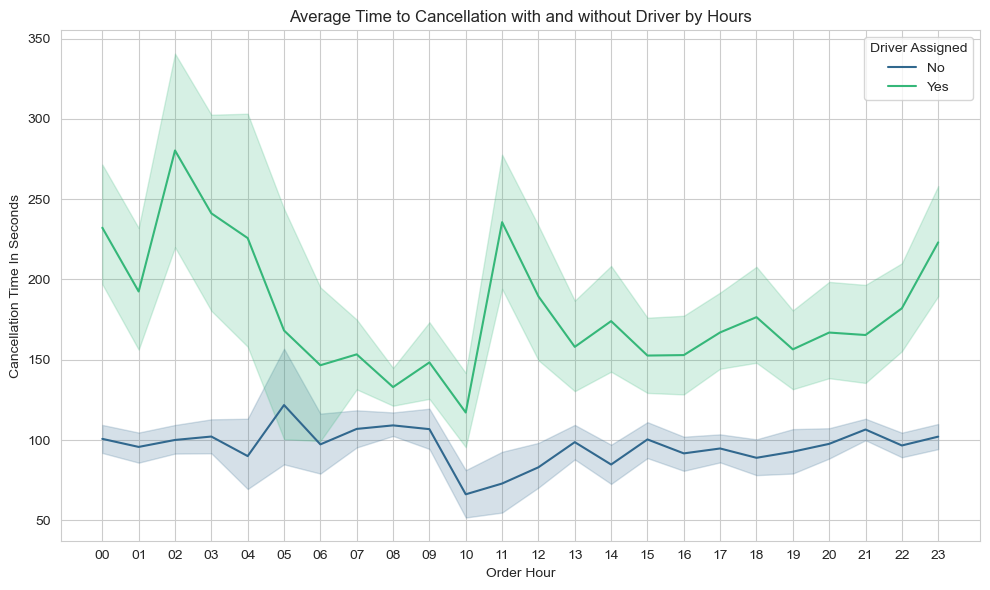

In [22]:
# 绘图
plt.figure(figsize=(10, 6))
# 同时绘制95%置信区间
sns.lineplot(x='Order Hour', y='cancellations_time_in_seconds', hue='Driver Assigned', markers=True,
             data=df_gett_new, palette='viridis', ci=95, err_style="band")
plt.title('Average Time to Cancellation with and without Driver by Hours')
plt.xlabel('Order Hour')
plt.ylabel('Cancellation Time In Seconds')
plt.tight_layout()

plt.savefig("figures/Q3.jpg", dpi=400)
plt.show()

### Q4

C:\Users\john\AppData\Local\Temp\ipykernel_11536\4183314678.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(x='Order Hour', y='m_order_eta', markers=True,
C:\Users\john\AppData\Local\Temp\ipykernel_11536\4183314678.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x='Order Hour', y='m_order_eta', markers=True,


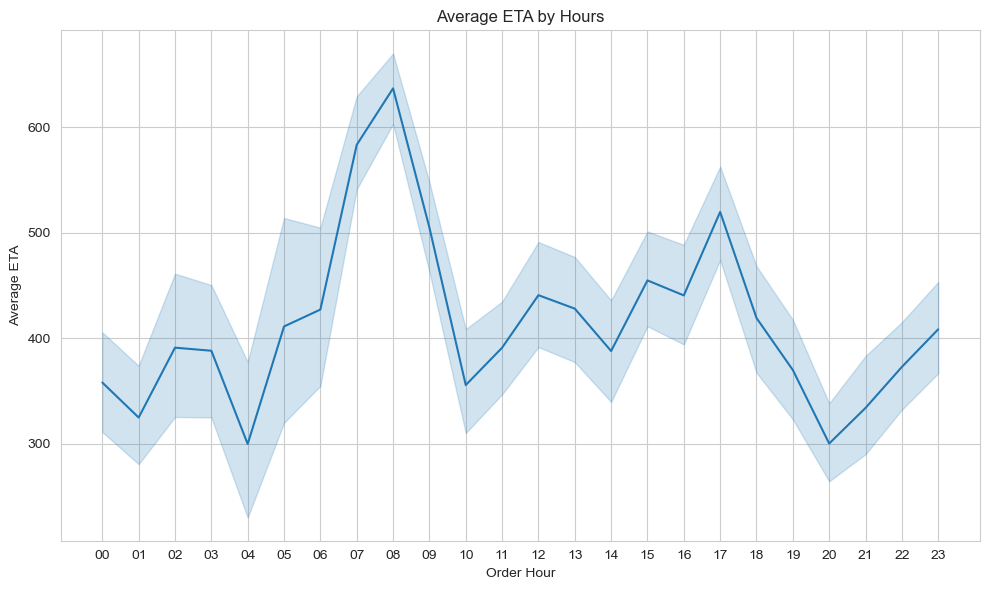

In [23]:
# 按 'Order Hour' 列排序
df_gett.sort_values(by='Order Hour', inplace=True)

#绘图
plt.figure(figsize=(10, 6))

# 同时绘制95%置信区间
sns.lineplot(x='Order Hour', y='m_order_eta', markers=True,
             data=df_gett, palette='viridis', ci=95, err_style="band")
plt.title('Average ETA by Hours')
plt.xlabel('Order Hour')
plt.ylabel('Average ETA')
plt.tight_layout()

plt.savefig("figures/Q4.jpg", dpi=400)
plt.show()

### Q5

In [24]:
import folium
import json
import geojson
import matplotlib.cm
import matplotlib.colors
import h3

In [25]:
# Function to convert latitude and longitude to H3 index
def lat_lon_to_h3(row):
    lat = row['origin_latitude']
    lon = row['origin_longitude']
    h3_index = h3.geo_to_h3(lat, lon, 8)  # Resolution 8
    return h3_index

# Apply the function to create a new column 'h3_index'
df_gett['h3_index'] = df_gett.apply(lat_lon_to_h3, axis=1)
# Calculate total count of orders
total_orders = df_gett.shape[0]
# Calculate the count for each hexagon
hexagon_counts = df_gett['h3_index'].value_counts().reset_index()
hexagon_counts = hexagon_counts.sort_values(by="count")  
total_orders = hexagon_counts["count"].sum()  
hexagon_counts["cum_sum"] = hexagon_counts["count"].cumsum()  
hexagon_counts["cum_perc"] = 100 * hexagon_counts["cum_sum"] / total_orders  

# Filtering hexagons that represent 80% of the total orders
hexagons_80_percent = hexagon_counts[hexagon_counts["cum_perc"] <= 80]

# Printing the number of hexagons representing 80% of total orders and total number of hexagons
print(hexagons_80_percent.shape[0])
print(hexagon_counts.shape[0])

142
144


142 hexagons contain around 80% of data, and only 2 hexagons contain the other 20% of the whole data.

In [26]:
# Create a folium map
m = folium.Map(location=[df_gett['origin_latitude'].mean(), df_gett['origin_longitude'].mean()], zoom_start=12, control_scale=True)

# Function to transform H3 indexes into GeoJSON objects
def to_geojson(row):
    """
    Transform hex_id into a geojson object.
    """
    geometry = {
        "type": "Polygon",
        "coordinates": [h3.h3_to_geo_boundary(h=row["h3_index"], geo_json=True)]
    }
    result = geojson.Feature(id=row["h3_index"], geometry=geometry, properties={"count": row['count']})
    return result

# Convert hexagon counts to GeoJSON format
geojsons = hexagon_counts.apply(func=to_geojson, axis=1).values.tolist()
geojson_str: str = json.dumps(geojson.FeatureCollection(geojsons))

# Define colormap for visualization
colormap = matplotlib.cm.get_cmap(name="YlOrRd")
max_order_gk = hexagon_counts["count"].max()
min_order_gk = hexagon_counts["count"].min()

def style_function(feature):
    """
    Style function for the GeoJson layer.
    """
    count = feature["properties"]["count"]
    color = matplotlib.colors.rgb2hex(colormap((count - min_order_gk) / (max_order_gk - min_order_gk)))
    return {
        "fillColor": color,
        "color": "black",
        "weight": 1,
        "fillOpacity": 0.7
    }
# Create GeoJson layer with styled features and tooltips
to_add = folium.GeoJson(data=geojson_str, style_function=style_function, tooltip=folium.GeoJsonTooltip(fields=['count'], labels=True))
to_add.add_to(m)

# Save the map to an HTML file
m.save('order_hexagons.html')

m